In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import glob, os, string, nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm
    
    return similarity

In [3]:
doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']
tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [4]:
feature_vect_dense = feature_vect_simple.todense()
print(feature_vect_dense[0])
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
print(vect1)
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect2)
print(similarity_simple)

[[0.4155636  0.         0.4155636  0.         0.         0.
  0.24543856 0.         0.24543856 0.         0.         0.
  0.         0.4155636  0.24543856 0.49087711 0.         0.24543856]]
[0.4155636  0.         0.4155636  0.         0.         0.
 0.24543856 0.         0.24543856 0.         0.         0.
 0.         0.4155636  0.24543856 0.49087711 0.         0.24543856]
0.4020775821495014


In [5]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [7]:
# sklearn cosine similarity module can deal with sparse matrix
similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [8]:
# pair
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]


In [12]:
# opinion review data
path = r'C:\Users\AMD3600\Documents\Text_data\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = []
opinion_text = []

In [13]:
for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

In [18]:
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [22]:
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                            ngram_range=(1, 2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\AMD3600\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [34]:
hotel_indexes = document_df[document_df['cluster_label']==1].index
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

Int64Index([2, 3, 4, 19, 26, 42, 44], dtype='int64')
[[1.         0.82294058 0.85123184 0.11082545 0.29142722 0.09144013
  0.0194904 ]]


[[0 2 1 4 3 5 6]]
[[2 1 4 3 5 6]]
Int64Index([4, 3, 26, 19, 42, 44], dtype='int64')
[1.         0.85123184 0.82294058 0.29142722 0.11082545 0.09144013
 0.0194904 ]
[0.85123184 0.82294058 0.29142722 0.11082545 0.09144013 0.0194904 ]


Text(0.5, 1.0, 'battery-life_amazon_kindle')

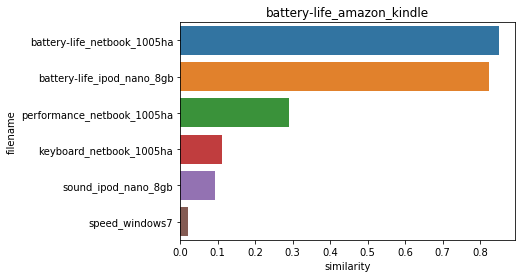

In [33]:
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]

hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]


hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)